In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import librosa
from sklearn.decomposition import PCA
import torch
from scipy.stats import skew, kurtosis
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

### Function to create MFCC coefficients

In [2]:
def create_MFCC_coefficients(file_name):
    sr_value = 44100
    n_mfcc_count = 20
    try:
        y, sr = librosa.load(file_name, sr=sr_value)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc_count)
        coeff_df = pd.DataFrame(mfccs)
        return coeff_df.T
    except:
        return None

## GTZAN data for pretraining 

In [3]:
L = 2584
gtzan_Data = []
gtzan_Label = []
scaler = MinMaxScaler()
folder_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
folder_names = os.listdir(folder_path)

for folder in folder_names:
    file_names = os.listdir(os.path.join(folder_path, folder))
    for file in file_names:
        file_path = os.path.join(folder_path, folder, file)
        mfcc_data = create_MFCC_coefficients(file_path) 
        if mfcc_data is not None:
            delta_mfcc = librosa.feature.delta(mfcc_data)
            delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
            interleaved_mfcc = np.empty((mfcc_data.shape[1] * 3, mfcc_data.shape[0]))
            for i in range(mfcc_data.shape[1]):
                interleaved_mfcc[i * 3] = mfcc_data[i]
                interleaved_mfcc[i * 3 + 1,:] = delta_mfcc[:,i]
                interleaved_mfcc[i * 3 + 2,:] = delta2_mfcc[:,i]
            mfcc_data_scaled = scaler.fit_transform(interleaved_mfcc).T

            if len(mfcc_data_scaled) < L:
                padding = L - len(mfcc_data_scaled)
                mfcc_data_scaled = np.pad(mfcc_data_scaled, ((padding // 2, padding - padding // 2), (0, 0)), mode='constant')
            elif len(mfcc_data_scaled) > L:
                mfcc_data_scaled = mfcc_data_scaled[:L, :]

            gtzan_Data.append(np.array(mfcc_data_scaled))
            gtzan_Label.append(folder)

/tmp/ipykernel_30/1861942266.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=sr_value)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


<Axes: >

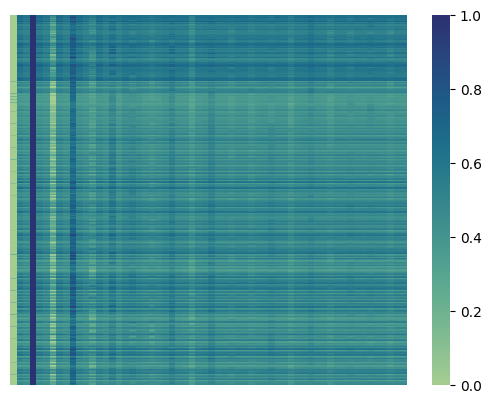

In [4]:
sns.heatmap(gtzan_Data[0],cmap='crest', xticklabels=False, yticklabels=False)

In [5]:
label_encoder = LabelEncoder()
gtzan_Label = label_encoder.fit_transform(gtzan_Label)

In [6]:
def create_sandwiched_vgg19(input_shape=(2584, 60, 1), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(128, (3, 3), padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.MaxPooling2D((8, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.MaxPooling2D((8, 2))(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.Conv2D(3, (3, 3), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.UpSampling2D(size=(8, 8))(x)
    base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(320, 120, 3))
    base_model.trainable = False
    x = base_model(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

model = create_sandwiched_vgg19()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2584, 60, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2584, 60, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2584, 60, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 323, 30, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 323, 30, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 323, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 15, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 40, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 15, 3)      │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 40, 15, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 320, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 10, 3, 512)     │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,053,773 (91.76 MB)

 Trainable params: 4,029,389 (15.37 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [7]:
Data = np.array(gtzan_Data)
labels = np.array(gtzan_Label)
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.1, random_state=42)

In [8]:
model.fit(X_train,y_train,epochs = 50,batch_size = 32,validation_split = 0.2)

Epoch 1/50


I0000 00:00:1730630634.506988     113 service.cc:145] XLA service 0x7df900114a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730630634.507050     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730630654.151648     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.0897 - loss: 4.0514 - val_accuracy: 0.1278 - val_loss: 2.3459
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.1367 - loss: 2.3092 - val_accuracy: 0.1556 - val_loss: 2.2443
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.1869 - loss: 2.1934 - val_accuracy: 0.1833 - val_loss: 2.1127
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.2849 - loss: 2.0440 - val_accuracy: 0.1667 - val_loss: 2.0683
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.2882 - loss: 1.9577 - val_accuracy: 0.2833 - val_loss: 1.8978
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.3656 - loss: 1.7934 - val_accuracy: 0.2889 - val_loss: 1.8734
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.4118 - loss: 1.7322 - val_accuracy: 0.2611 - val_loss: 1.8923
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.4191 - loss: 1.6005 - val_accuracy: 0.3278 - val_lo

In [9]:
loss , accuracy = model.evaluate(X_test,y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 861ms/step - accuracy: 0.4865 - loss: 1.7187


## Fine tuning on our data

In [10]:
L = 2584  # Target number of frames
Data = []
Label = []
scaler = MinMaxScaler()
folder_path = '/kaggle/input/ds203-songs'
folder_names = os.listdir(folder_path)

for folder in folder_names:
    folder__names = os.listdir(os.path.join(folder_path, folder))
    for folder_ in folder__names:
        file_names = os.listdir(os.path.join(folder_path, folder, folder_))
        for file in file_names:
            file_path = os.path.join(folder_path, folder, folder_, file)
            mfcc_data = create_MFCC_coefficients(file_path)  # Ensure this function is defined
            
            if mfcc_data is not None:
                delta_mfcc = librosa.feature.delta(mfcc_data)
                delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
                interleaved_mfcc = np.empty((mfcc_data.shape[1] * 3, mfcc_data.shape[0]))
                for i in range(mfcc_data.shape[1]):
                    interleaved_mfcc[i * 3] = mfcc_data[i]
                    interleaved_mfcc[i * 3 + 1, :] = delta_mfcc[:, i]
                    interleaved_mfcc[i * 3 + 2, :] = delta2_mfcc[:, i]
                
                mfcc_data_scaled = scaler.fit_transform(interleaved_mfcc).T
                num_segments = len(mfcc_data_scaled) // L
                if len(mfcc_data_scaled) >= L:
                    for i in range(num_segments):
                        segment = mfcc_data_scaled[i * L : (i + 1) * L, :]
                        Data.append(np.array(segment))
                        Label.append(folder_)
                else:
                    padding = L - len(mfcc_data_scaled)
                    mfcc_data_scaled_padded = np.pad(mfcc_data_scaled, ((padding // 2, padding - padding // 2), (0, 0)), mode='constant')
                    Data.append(np.array(mfcc_data_scaled_padded))
                    Label.append(folder_)

In [11]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(Label)

In [12]:
Feature_extractor = Model(inputs=model.input,outputs=model.get_layer('dense').output)

In [13]:
x = layers.Dropout(0.1)(Feature_extractor.output)
x = layers.Dense(6, activation='softmax')(x)
fine_tuned_model = Model(inputs=Feature_extractor.input, outputs=x)
fine_tuned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fine_tuned_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2584, 60, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2584, 60, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2584, 60, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 323, 30, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 323, 30, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 323, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 15, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 40, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 15, 3)      │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 40, 15, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 320, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 10, 3, 512)     │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,052,745 (91.75 MB)

 Trainable params: 4,028,361 (15.37 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [14]:
Data = np.array(Data)
labels = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.1, random_state=42)

In [15]:
fine_tuned_model.fit(X_train,y_train,epochs = 20,batch_size = 32,validation_split = 0.2)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.2779 - loss: 12.0085 - val_accuracy: 0.4395 - val_loss: 4.5957
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.4194 - loss: 5.1582 - val_accuracy: 0.5732 - val_loss: 1.6579
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.4930 - loss: 2.9923 - val_accuracy: 0.4841 - val_loss: 1.9706
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.5195 - loss: 2.3614 - val_accuracy: 0.6497 - val_loss: 1.4765
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.5847 - loss: 2.1007 - val_accuracy: 0.6306 - val_loss: 1.3434
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.5893 - loss: 1.9357 - val_accuracy: 0.6051 - val_loss: 2.2678
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.6567 - loss: 1.8113 - val_accuracy: 0.6433 - val_loss: 1.3856
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.6056 - loss: 1.9176 - val_accuracy: 0.5

In [16]:
loss , accuracy = model.evaluate(X_test,y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.0639 - loss: 12.5610


## Predicting for the given data

In [17]:
scaler = MinMaxScaler()
folder_path = '/kaggle/input/ds203-v2-dataset/MFCC-files-v2-20241024'
file_names = os.listdir(folder_path)
Data = []
meta_data = []
L = 2584  # Target number of frames

for file in file_names:
    file_path = os.path.join(folder_path, file)
    meta_data.append(file)
    df = pd.read_csv(file_path, header=None)
    mfcc_data = df.T
    delta_mfcc = librosa.feature.delta(mfcc_data)
    delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
    interleaved_mfcc = np.empty((mfcc_data.shape[1] * 3, mfcc_data.shape[0]))
    for i in range(mfcc_data.shape[1]):
        interleaved_mfcc[i * 3] = mfcc_data[i]
        interleaved_mfcc[i * 3 + 1,:] = delta_mfcc[:,i]
        interleaved_mfcc[i * 3 + 2,:] = delta2_mfcc[:,i]
    mfcc_data_scaled = scaler.fit_transform(interleaved_mfcc).T
    if len(mfcc_data_scaled) < L:
        padding = L - len(mfcc_data_scaled)
        mfcc_data_scaled = np.pad(mfcc_data_scaled, ((padding // 2, padding - padding // 2), (0, 0)), mode='constant')
    elif len(mfcc_data_scaled) > L:
        mfcc_data_scaled = mfcc_data_scaled[:L, :]
    Data.append(mfcc_data_scaled)
Data = np.array(Data)

In [18]:
predictions = fine_tuned_model.predict(Data)
predicted_labels = predictions.argmax(axis=1)
original_labels = label_encoder.inverse_transform(predicted_labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step


In [20]:
result_df = pd.DataFrame({'Label': original_labels, 'MetaData': meta_data})
result_df.to_csv('result.csv', index=False)
result_df.head()

,Label,MetaData
0,Asha_Bhosale,70-MFCC.csv
1,Michael Jackson,104-MFCC.csv
2,KISHORE_KUMAR,67-MFCC.csv
3,KISHORE_KUMAR,110-MFCC.csv
4,Asha_Bhosale,92-MFCC.csv


In [21]:
Feature_extractor = Model(inputs=fine_tuned_model.input,outputs=fine_tuned_model.get_layer('dense').output)

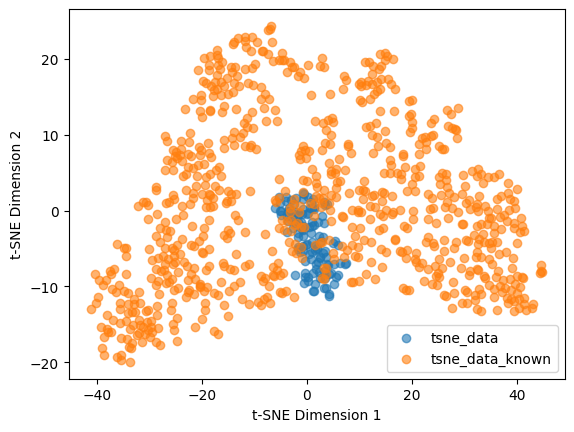

In [22]:
Features = []
for i in range(len(Data)):
    Features.append(Feature_extractor(Data[i].reshape(1,2584,60,1))[0])
Features_known = []
for i in range(len(X_train)):
    Features_known.append(Feature_extractor(X_train[i].reshape(1,2584,60,1))[0])
Features = np.array(Features)
Features_known = np.array(Features_known)
model = TSNE(n_components = 2, random_state = 0)
tsne_data = model.fit_transform(Features)
tsne_data_known = model.fit_transform(Features_known)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], label="tsne_data", alpha=0.6)
plt.scatter(tsne_data_known[:, 0], tsne_data_known[:, 1], label="tsne_data_known", alpha=0.6)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

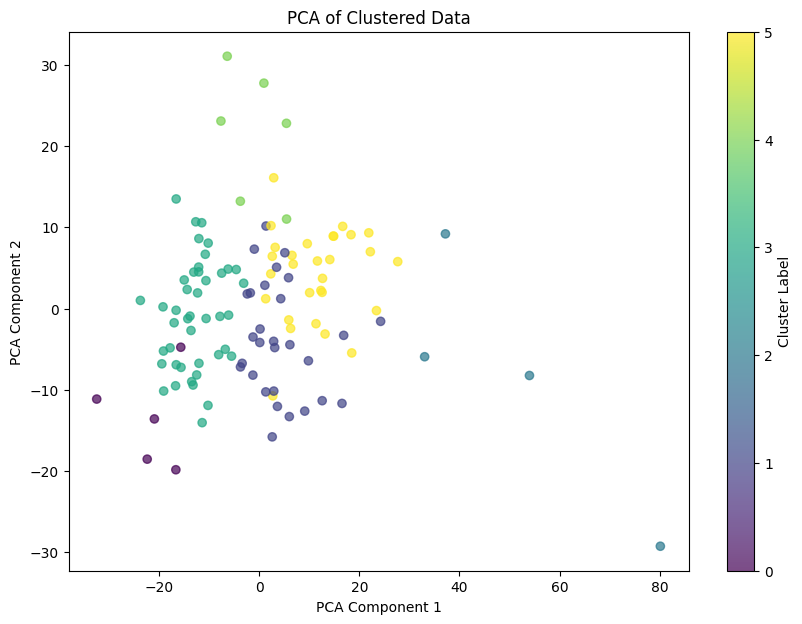

In [23]:
kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(Features)
Cluster_label = kmeans.labels_
pca = PCA(n_components=2)
features_pca = pca.fit_transform(Features)

# Plotting
plt.figure(figsize=(10, 7))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=Cluster_label, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")  
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Clustered Data")
plt.show()

In [24]:
result_df = pd.DataFrame({'CLuster_Label': Cluster_label, 'MetaData': meta_data})
result_df.to_csv('Cluster.csv', index=False)
result_df.head()

,CLuster_Label,MetaData
0,5,70-MFCC.csv
1,2,104-MFCC.csv
2,3,67-MFCC.csv
3,4,110-MFCC.csv
4,3,92-MFCC.csv
